In [72]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [121]:
import lib

import torch
import torchvision
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from torchvision.datasets import ImageFolder

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from math import floor, ceil
from sklearn.model_selection import train_test_split
from scipy import stats
import plotly.express as px
import seaborn as sns

import shutil
import requests
import functools
import pathlib
from pathlib import Path
import shutil
from tqdm.auto import tqdm
import os
from collections import defaultdict
import pickle

from IPython.display import clear_output

sns.set_theme()
matplotlib.rcParams['figure.figsize'] = (30, 5)

In [74]:
IMAGE_SHAPE = (384, 512)

DATA_ROOT = Path('iqa')

In [75]:
class IQADataset(Dataset):
    def __init__(self, images_path, labels_path, mode, transforms=None):
        assert mode in ['train', 'valid', 'test', 'all']
        TRAIN_RATIO = 0.7
        TRAIN_VALID_RATIO = 0.8
        self.images_path = images_path
        self.files = os.listdir(images_path)
        self.labels_path = labels_path

        df = pd.read_csv(labels_path).astype('float32', errors='ignore')
        train_size = int(TRAIN_RATIO * len(df))
        train_valid_size = int(TRAIN_VALID_RATIO * len(df))

        if mode == 'train':
            self.df = df.iloc[:train_size]
        elif mode == 'valid':
            self.df = df.iloc[train_size:train_valid_size]
        elif mode == 'test':
            self.df = df.iloc[train_valid_size:]
        elif mode == 'all':
            self.df = df

        self.transforms = transforms
        self.default_size = (500, 500)
        self.mode = mode

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index) -> tuple:
        name, subj_mean, subj_std = self.df.iloc[index]
        image = cv2.imread(str(self.images_path / name))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if image.ndim == 2:
            image = np.expand_dims(image, 2)

        if image.shape[:2] != self.default_size:
            image = cv2.resize(image, self.default_size)

        if self.transforms:
            image = self.transforms(image=image)['image']
        return {'image': image, 'name': name, 'subj_mean': subj_mean, 'subj_std': subj_std}

In [125]:
transforms = A.Compose([
    A.Resize(*IMAGE_SHAPE),
    A.HorizontalFlip(),
    A.Normalize(),
    ToTensorV2(),
])
dataset_train = IQADataset(images_path=DATA_ROOT / 'koniq10k' / 'images', labels_path=DATA_ROOT / 'koniq_data.csv', mode='train', transforms=transforms)
dataset_valid = IQADataset(images_path=DATA_ROOT / 'koniq10k' / 'images', labels_path=DATA_ROOT / 'koniq_data.csv', mode='valid', transforms=transforms)
dataset_test = IQADataset(images_path=DATA_ROOT / 'CLIVE' / 'images', labels_path=DATA_ROOT / 'clive_data.csv', mode='all', transforms=transforms)

loader_train = DataLoader(dataset_train, batch_size=16, shuffle=True, num_workers=16)
loader_valid = DataLoader(dataset_valid, batch_size=16, shuffle=True, num_workers=16)
loader_test = DataLoader(dataset_test, batch_size=16, shuffle=True, num_workers=16)


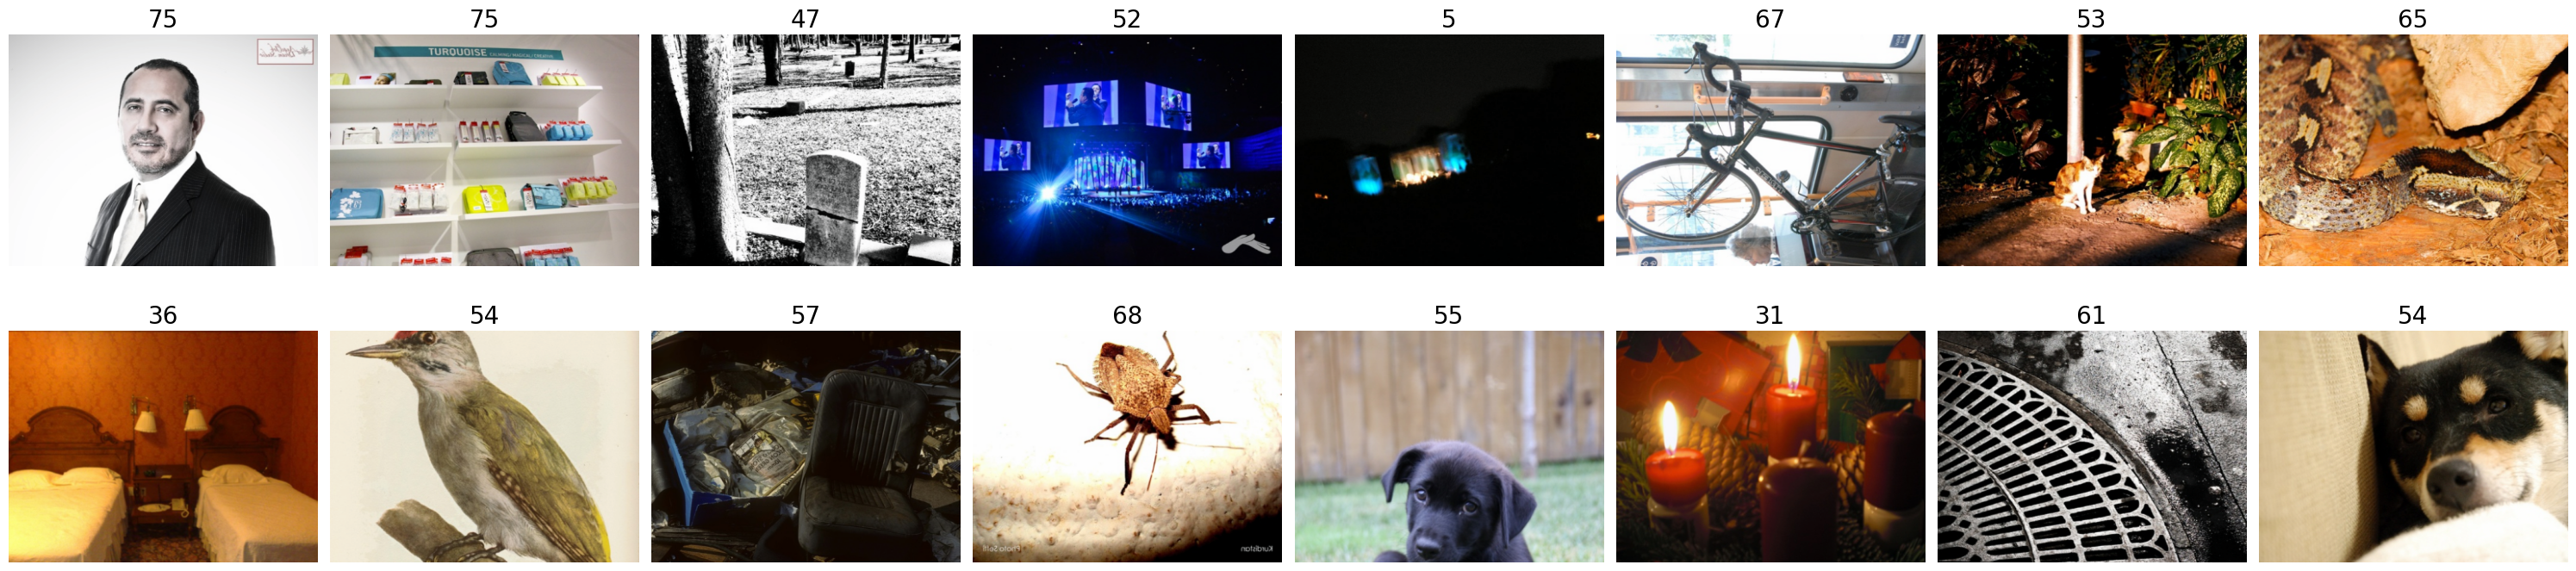

In [77]:
batch = next(iter(loader_train))
lib.display_batch(batch, 'subj_mean')

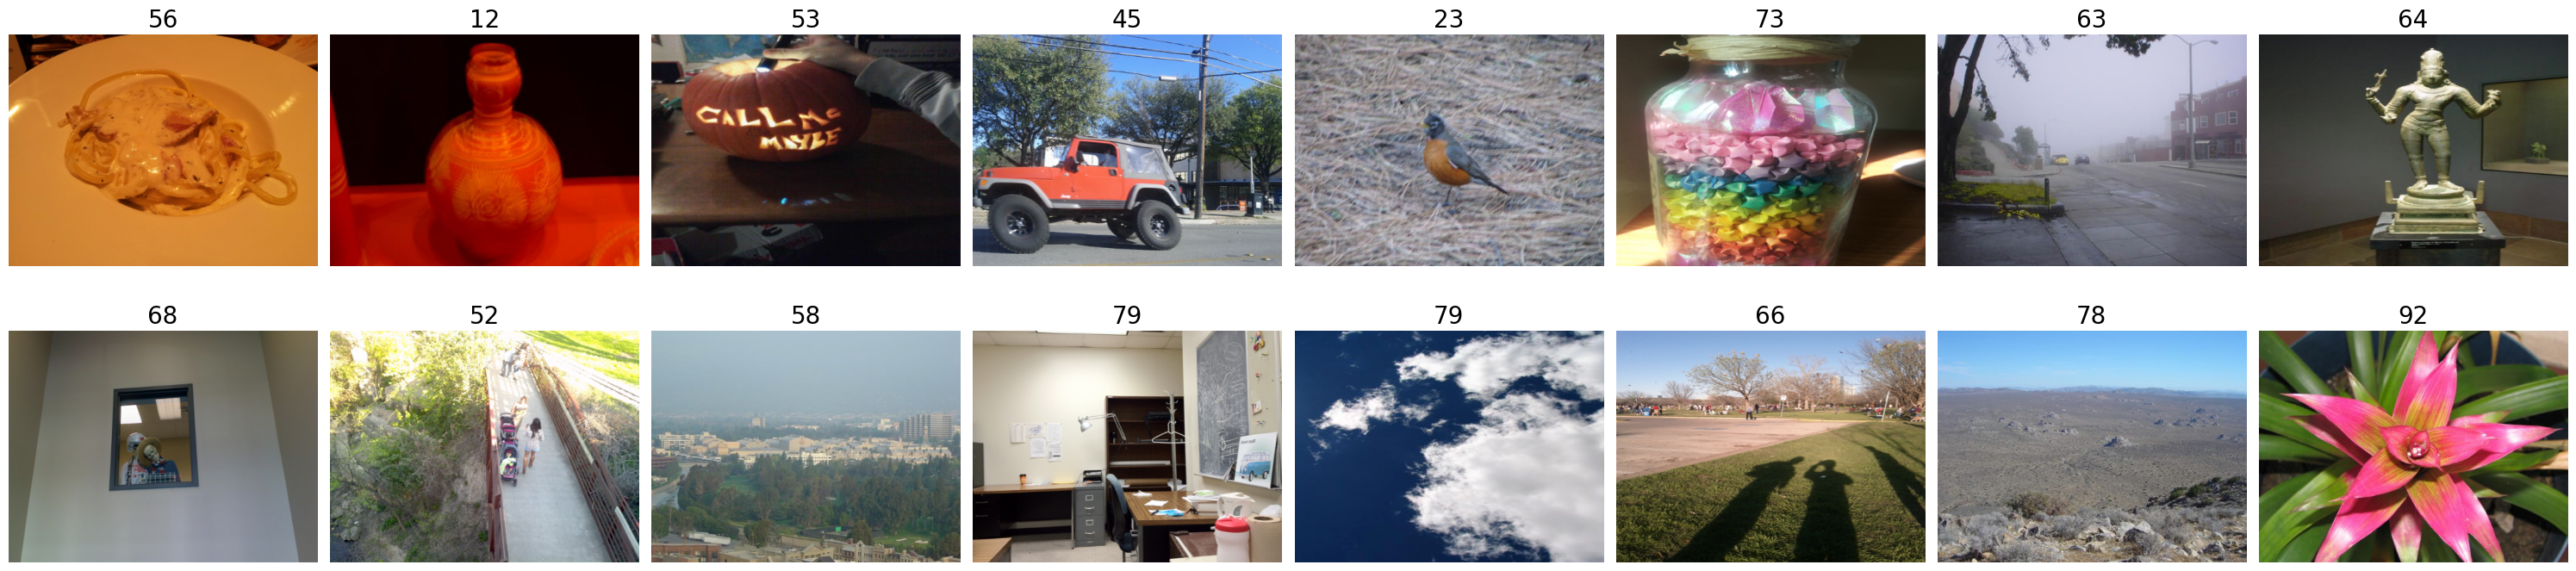

In [78]:
batch = next(iter(loader_valid))
lib.display_batch(batch, 'subj_mean')

In [92]:
class LinearBlock(nn.Module):
    def __init__(self, in_dim, out_dim, dropout, activation=True):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        if activation:
            self.layers = nn.Sequential(
                nn.Dropout(dropout),
                nn.Linear(in_dim, out_dim),
                nn.BatchNorm1d(out_dim),
                nn.ReLU(),
            )
        else:
            self.layers = nn.Sequential(
                nn.Dropout(dropout),
                nn.Linear(in_dim, out_dim),
            )

    def forward(self, x):
        return self.layers(x)

class Model(pl.LightningModule):
    def __init__(self):
        super().__init__()

        backbone = torchvision.models.efficientnet_b2(weights=torchvision.models.EfficientNet_B2_Weights.IMAGENET1K_V1)
        backbone = list(backbone.children())[:-2]
        backbone = nn.Sequential(*backbone)

        self.backbone = backbone
        
        self.mlp = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            LinearBlock(1408, 1024, 0.25),
            LinearBlock(1024, 256, 0.25),
            LinearBlock(256, 1, 0, activation=False)
        )

        self.loss = nn.MSELoss()

    def forward(self, x):
        x = self.backbone(x)
        x = self.mlp(x)
        return x

    def training_step(self, batch, batch_idx):
        """the full training loop"""
        x, y = batch['image'], batch['subj_mean']
        pred = self(x).flatten()
        loss = self.loss(pred, y)
        true = y.detach().cpu().numpy()
        pred = pred.detach().cpu().numpy()
        return {'loss': loss, 'results': (true, pred)}
    
    # OPTIONAL
    def validation_step(self, batch, batch_idx):
        """the full validation loop"""
        x, y = batch['image'], batch['subj_mean']
        pred = self(x).flatten()
        loss = self.loss(pred, y)
        true = y.detach().cpu().numpy()
        pred = pred.detach().cpu().numpy()
        return {'loss': loss, 'results': (true, pred)}

    def configure_optimizers(self):
        """ Define optimizers and LR schedulers. """
        optimizer = torch.optim.Adam([
            {'params': self.backbone.parameters(), 'lr': 3e-5},
            {'params': self.mlp.parameters(), 'lr': 3e-4}
        ], weight_decay=3e-4)

        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, 
            mode='max', 
            factor=0.2, 
            patience=5, 
            verbose=True)
            
        lr_dict = {
            "scheduler": lr_scheduler,
            "interval": "epoch",
            "frequency": 1,
            "monitor": "val_srocc"
        } 

        return [optimizer], [lr_dict]

    # OPTIONAL
    def training_epoch_end(self, outputs):
        """log and display average train loss and accuracy across epoch"""
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        true = np.concatenate([x['results'][0] for x in outputs])
        predicted = np.concatenate([x['results'][1] for x in outputs])

        plcc = stats.pearsonr(predicted, true)[0]
        srocc = stats.spearmanr(predicted, true)[0]

        print(f"| TRAIN plcc: {plcc:.2f}, srocc: {srocc:.2f}, loss: {avg_loss:.2f}" )

        self.log('train_loss', avg_loss, prog_bar=True, on_epoch=True, on_step=False)
        self.log('train_plcc', plcc, prog_bar=True, on_epoch=True, on_step=False)
        self.log('train_srocc', srocc, prog_bar=True, on_epoch=True, on_step=False)

    # OPTIONAL
    def validation_epoch_end(self, outputs):
        """log and display average val loss and accuracy"""
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        true = np.concatenate([x['results'][0] for x in outputs])
        predicted = np.concatenate([x['results'][1] for x in outputs])
        
        plcc = stats.pearsonr(predicted, true)[0]
        srocc = stats.spearmanr(predicted, true)[0]

        print(f"[Epoch {self.trainer.current_epoch:3}] VALID plcc: {plcc:.2f}, srocc: {srocc:.2f}, loss: {avg_loss:.2f}", end= " ")

        self.log('val_loss', avg_loss, prog_bar=True, on_epoch=True, on_step=False)
        self.log('val_plcc', plcc, prog_bar=True, on_epoch=True, on_step=False)
        self.log('val_srocc', srocc, prog_bar=True, on_epoch=True, on_step=False)

In [93]:
MyModelCheckpoint = ModelCheckpoint(dirpath='checkpoints/',
                                    filename='{epoch}_{val_srocc:.3f}_{val_plcc:.3f}_{val_loss:.3f}',
                                    monitor='val_srocc', 
                                    mode='max', 
                                    save_top_k=1,
                                    save_weights_only=True,
                                    verbose=False)

MyEarlyStopping = EarlyStopping(monitor = "val_srocc",
                                mode = "max",
                                patience = 15,
                                verbose = True)

trainer = pl.Trainer(
    max_epochs=100,
    accelerator='gpu',
    devices=[0],
    callbacks=[MyEarlyStopping, MyModelCheckpoint],
    log_every_n_steps=1,
)

model = Model()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [94]:
trainer.fit(model, loader_train, loader_valid)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name     | Type       | Params
----------------------------------------
0 | backbone | Sequential | 7.7 M 
1 | mlp      | Sequential | 1.7 M 
2 | loss     | MSELoss    | 0     
----------------------------------------
9.4 M     Trainable params
0         Non-trainable params
9.4 M     Total params
37.636    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

32 32
[Epoch   0] VALID plcc: 0.28, srocc: 0.29, loss: 3893.70 

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_srocc improved. New best score: 0.736


1007 1007
[Epoch   0] VALID plcc: 0.75, srocc: 0.74, loss: 1535.24 | TRAIN plcc: 0.47, srocc: 0.52, loss: 2534.98


Validation: 0it [00:00, ?it/s]

Metric val_srocc improved by 0.096 >= min_delta = 0.0. New best score: 0.832


1007 1007
[Epoch   1] VALID plcc: 0.85, srocc: 0.83, loss: 271.58 | TRAIN plcc: 0.69, srocc: 0.67, loss: 731.00


In [ ]:
model.load_state_dict(torch.load('/home/alexkkir/experiments-with-saliency/checkpoints/epoch=33_val_srocc=0.889_val_plcc=0.923_val_loss=36.742.ckpt')['state_dict'])
model.eval()
clear_output()

In [126]:
trainer.validate(model, loader_test)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/home/alexkkir/anaconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning:

Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.



Validation: 0it [00:00, ?it/s]

1162 1162
[Epoch   2] VALID plcc: 0.84, srocc: 0.81, loss: 125.94 ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            125.94258117675781
        val_plcc            0.8419396384984268
        val_srocc           0.8135264519102555
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 125.94258117675781,
  'val_plcc': 0.8419396384984268,
  'val_srocc': 0.8135264519102555}]

In [105]:
device = torch.device('cuda:1')
model.to(device)
model.eval()
clear_output()

In [106]:
df = dataset_valid.df.copy().set_index('name')
df['pred'] = .0
for i, sample in tqdm(enumerate(dataset_valid), total=len(df)):
    image = sample['image'].unsqueeze(0).to(device)
    name = sample['name']
    pred = model(image)
    pred = float(pred.detach().cpu())
    df.loc[name, 'pred'] = pred

  0%|          | 0/1007 [00:00<?, ?it/s]

In [107]:
df.corr('pearson')

subj_mean  subj_std      pred
subj_mean   1.000000 -0.291821  0.921416
subj_std   -0.291821  1.000000 -0.200013
pred        0.921416 -0.200013  1.000000

In [108]:
np.mean((df.subj_mean - df.pred).values ** 2)

37.14286980295383

<AxesSubplot:xlabel='subj_mean', ylabel='pred'>

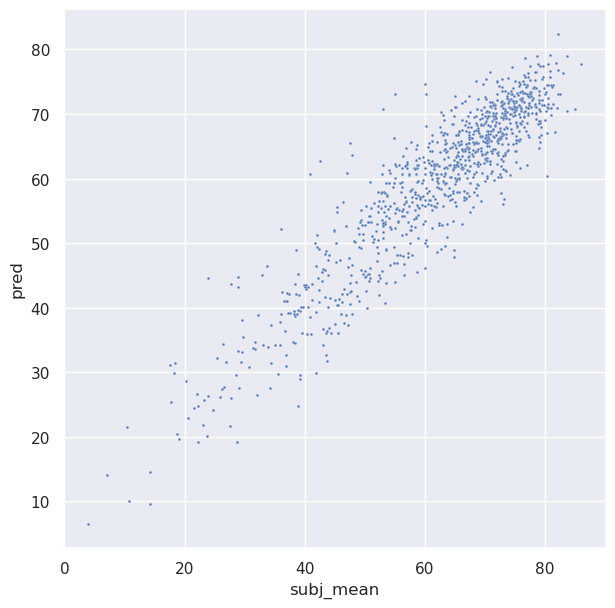

In [123]:
plt.figure(figsize=(7, 7))
sns.scatterplot(data=df, x='subj_mean', y='pred', s=4)

In [117]:
df.to_csv('efficient_results.csv')